### описание данных  

Технологический процесс  
 Rougher feed — исходное сырье  
Rougher additions (или reagent additions) — флотационные реагенты:   Xanthate, Sulphate, Depressant  
Xanthate **— ксантогенат (промотер, или активатор флотации);  
Sulphate — сульфат (на данном производстве сульфид натрия);  
Depressant — депрессант (силикат натрия).  
Rougher process (англ. «грубый процесс») — флотация  
Rougher tails — отвальные хвосты  
Float banks — флотационная установка  
Cleaner process — очистка  
Rougher Au — черновой концентрат золота  
Final Au — финальный концентрат золота  
### Параметры этапов  
air amount — объём воздуха  
fluid levels — уровень жидкости  
feed size — размер гранул сырья  
feed rate — скорость подачи  
### Наименование признаков  
Наименование признаков должно быть такое:  
[этап].[тип_параметра].[название_параметра]  
Пример: rougher.input.feed_ag  
### Возможные значения для блока [этап]:  
rougher — флотация  
primary_cleaner — первичная очистка  
secondary_cleaner — вторичная очистка  
final — финальные характеристики  
### Возможные значения для блока [тип_параметра]:  
input — параметры сырья  
output — параметры продукта  
state — параметры, характеризующие текущее состояние этапа  
calculation — расчётные характеристики  

## Подготовка данных

### Загружаем библиотеки

In [1]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor 
from sklearn.model_selection import cross_val_score
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

### Загружаем файлы

In [2]:
gold_train = pd.read_csv('/datasets/gold_recovery_train.csv')
gold_test = pd.read_csv('/datasets/gold_recovery_test.csv')
gold_full = pd.read_csv('/datasets/gold_recovery_full.csv')

In [6]:
gold_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22716 entries, 0 to 22715
Data columns (total 87 columns):
date                                                  22716 non-null object
final.output.concentrate_ag                           22627 non-null float64
final.output.concentrate_pb                           22629 non-null float64
final.output.concentrate_sol                          22331 non-null float64
final.output.concentrate_au                           22630 non-null float64
final.output.recovery                                 20753 non-null float64
final.output.tail_ag                                  22633 non-null float64
final.output.tail_pb                                  22516 non-null float64
final.output.tail_sol                                 22445 non-null float64
final.output.tail_au                                  22635 non-null float64
primary_cleaner.input.sulfate                         21107 non-null float64
primary_cleaner.input.depressant             

In [8]:
gold_train.corr().unstack().sort_values().drop_duplicates()

final.output.recovery                     final.output.tail_au                       -0.526151
primary_cleaner.output.tail_au            final.output.recovery                      -0.451250
final.output.tail_pb                      rougher.output.tail_sol                    -0.440548
rougher.input.feed_pb                     rougher.output.tail_sol                    -0.404631
secondary_cleaner.output.tail_pb          rougher.output.tail_ag                     -0.397804
                                                                                        ...   
rougher.state.floatbank10_b_air           rougher.state.floatbank10_c_air             0.973975
rougher.state.floatbank10_f_air           rougher.state.floatbank10_e_air             0.975193
primary_cleaner.state.floatbank8_b_level  primary_cleaner.state.floatbank8_a_level    0.980462
primary_cleaner.state.floatbank8_a_air    primary_cleaner.state.floatbank8_b_air      0.992513
final.output.concentrate_ag               final.ou

In [9]:
gold_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
date                                                  16860 non-null object
final.output.concentrate_ag                           16788 non-null float64
final.output.concentrate_pb                           16788 non-null float64
final.output.concentrate_sol                          16490 non-null float64
final.output.concentrate_au                           16789 non-null float64
final.output.recovery                                 15339 non-null float64
final.output.tail_ag                                  16794 non-null float64
final.output.tail_pb                                  16677 non-null float64
final.output.tail_sol                                 16715 non-null float64
final.output.tail_au                                  16794 non-null float64
primary_cleaner.input.sulfate                         15553 non-null float64
primary_cleaner.input.depressant             

### удаляем пропуски  
удаляем пропуски для того что бы посчитать среднее, и МАЕ

In [10]:
gold_train.dropna(inplace=True)

присваиваем переменные

In [11]:
c = gold_train['rougher.output.concentrate_au']
f = gold_train['rougher.input.feed_au']
t = gold_train['rougher.output.tail_au']

### функция расчета эффективности

In [12]:
def output_recovery(concetrat, feed, tail):
    recovery = ((concetrat * (feed - tail)) / (feed * (concetrat - tail))) * 100
    return recovery


In [13]:
mae_recovery = output_recovery(c, f, t) # вызываем функцию
mae_gold_train = gold_train['rougher.output.recovery']

вот тут есть сомнения в правильности решения

In [14]:
print(mae_recovery.mean()) # расчет среднего значения
print(mae_gold_train.mean())

82.7418884610155
82.7418884610155


### расчет МАЕ

и тут тоже преследуют сомнения

In [15]:
mae = mean_absolute_error(mae_gold_train, mae_recovery)
print('MAE: %f' % mae)

MAE: 0.000000


In [16]:
train_columns = gold_train.columns #получаем названия столбцов
test_columns = gold_test.columns

In [17]:
trest = list(set(train_columns) - set(test_columns)) # ищем разницу в столбцах
trest.sort()

In [18]:
trest

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.ta

Получили список столбцов, как видно это столбцы процесса очистки, они расчитываются по ходу производства, а значит в обучении не учавствуют

In [19]:
del trest[4] # удаляем из списка таргеты
del trest[24]
trest

['final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'rougher.output.tail_pb',
 'rougher.output.tail_sol',
 'secondary_cleane

In [20]:
for i in range(len(trest)): # удаляем столбцы из train
    gold_train.pop(trest[i])

In [22]:
gold_test = gold_test.dropna()

### добавление таргета в тест  
добавлеяем таргеты в тестовую выборку, и делаем подбор по дате

In [23]:
gold_test = gold_test.merge(gold_full[['date', 'final.output.recovery', 'rougher.output.recovery']], on='date', how='left')

удаляем пропуски,

In [24]:
gold_test = gold_test.dropna()

меняем тип данных для таргетов

In [25]:
gold_train['rougher.output.recovery'] = gold_train['rougher.output.recovery'].astype('int32')
gold_train['final.output.recovery'] = gold_train['final.output.recovery'].astype('int32')
gold_test['rougher.output.recovery'] = gold_test['rougher.output.recovery'].astype('int32')
gold_test['final.output.recovery'] = gold_test['final.output.recovery'].astype('int32')

берем features и Target

In [27]:
features_train = gold_train.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_train_roug = gold_train['rougher.output.recovery']
target_train_final = gold_train['final.output.recovery']


In [28]:
features_test = gold_test.drop(['final.output.recovery', 'rougher.output.recovery', 'date'], axis=1)
target_test_roug = gold_test['rougher.output.recovery']
target_test_final = gold_test['final.output.recovery']


In [29]:
features_train.shape, features_test.shape

((11017, 52), (5229, 52))

## Анализ Данных

### функция для просмотра концентрации металов

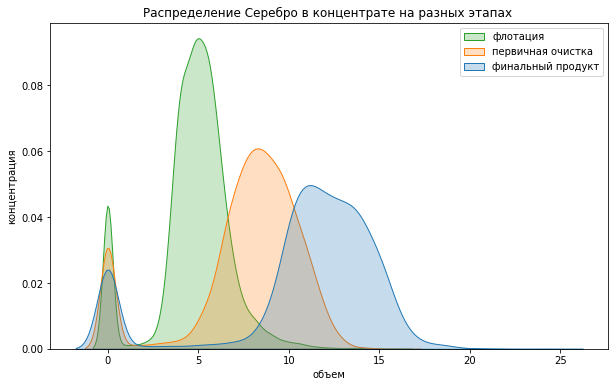

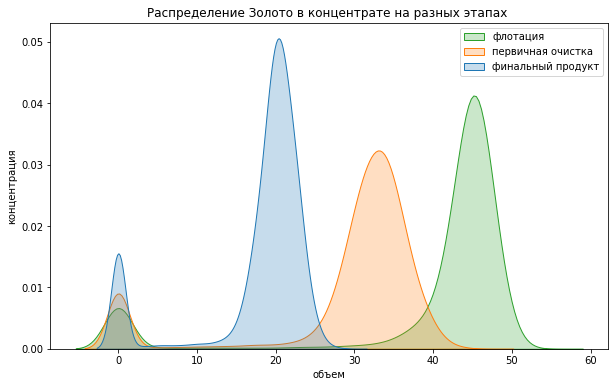

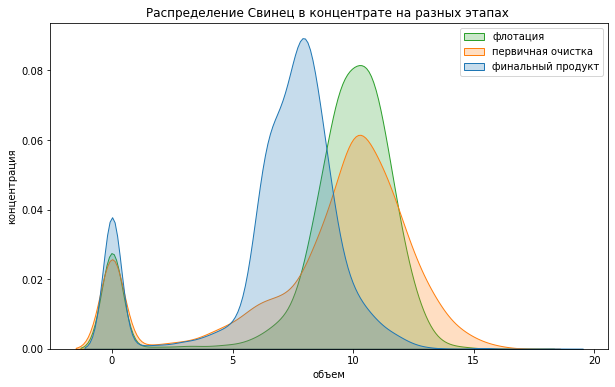

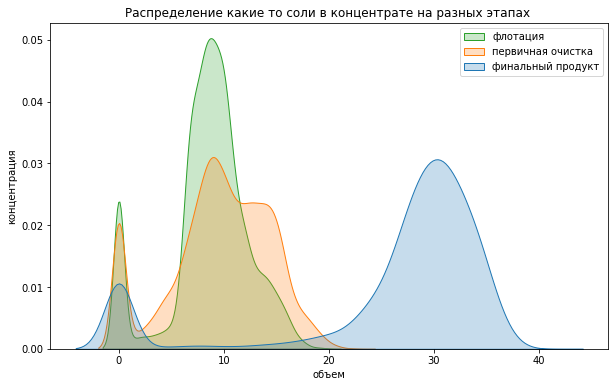

In [32]:
concent = {'Серебро':['rougher.output.concentrate_ag', 'primary_cleaner.output.concentrate_ag', 'final.output.concentrate_ag' ],
               'Золото':['rougher.output.concentrate_au', 'primary_cleaner.output.concentrate_au', 'final.output.concentrate_au' ],
               'Свинец':['rougher.output.concentrate_pb', 'primary_cleaner.output.concentrate_pb', 'final.output.concentrate_pb' ],
               'какие то соли':['rougher.output.concentrate_sol', 'primary_cleaner.output.concentrate_sol', 'final.output.concentrate_sol']}

for key in concent:
    plt.figure(figsize=(10,6))
    sns.kdeplot(data = gold_full[concent[key]], shade=True)
    plt.title(f'Распределение {key} в концентрате на разных этапах ')
    plt.legend(['флотация', 'первичная очистка', 'финальный продукт'])
    plt.ylabel('концентрация')
    plt.xlabel('объем')
    plt.show()

Text(0.5, 0, 'объем')

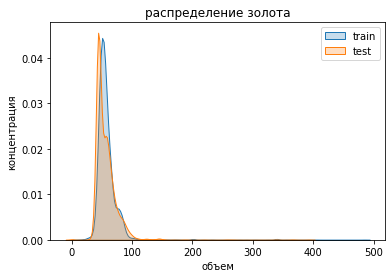

In [37]:
sns.kdeplot(gold_train['rougher.input.feed_size'], shade=True)
sns.kdeplot(gold_test['rougher.input.feed_size'], shade=True)
#gold_train['rougher.input.feed_size'].plot(kind='hist', bins=30, alpha=0.3)
#gold_test['rougher.input.feed_size'].plot(kind='hist', bins=30, alpha=0.3)
plt.title("распределение золота")
plt.legend(['train', 'test'])
plt.ylabel('концентрация')
plt.xlabel('объем')

In [43]:
def pfull():
    df_concentration = pd.DataFrame()

    df_concentration['input'] = gold_full['rougher.input.feed_ag'] + \
                                gold_full['rougher.input.feed_au'] + \
                                gold_full['rougher.input.feed_pb'] + \
                                gold_full['rougher.input.feed_sol']  

    df_concentration['rougher'] = gold_full['rougher.output.concentrate_ag'] + \
                                gold_full['rougher.output.concentrate_au'] + \
                                gold_full['rougher.output.concentrate_pb'] + \
                                gold_full['rougher.output.concentrate_sol']

    df_concentration['primary_cleaner'] = gold_full['primary_cleaner.output.concentrate_ag'] + \
                                gold_full['primary_cleaner.output.concentrate_au'] + \
                                gold_full['primary_cleaner.output.concentrate_pb'] + \
                                gold_full['primary_cleaner.output.concentrate_sol']

    df_concentration['final'] = gold_full['final.output.concentrate_ag'] + \
                                gold_full['final.output.concentrate_au'] + \
                                gold_full['final.output.concentrate_pb'] + \
                                gold_full['final.output.concentrate_sol']

    plt.figure(figsize=(15,10))
    sns.histplot(df_concentration, kde=True, bins=70)
    plt.title('суммарное распределение концентрате на разных этапах ')
    plt.legend(['сырье', 'флотация', 'очистка', 'финальный продукт'])
    plt.ylabel('концентрация')
    plt.xlabel('объем')
    plt.show()

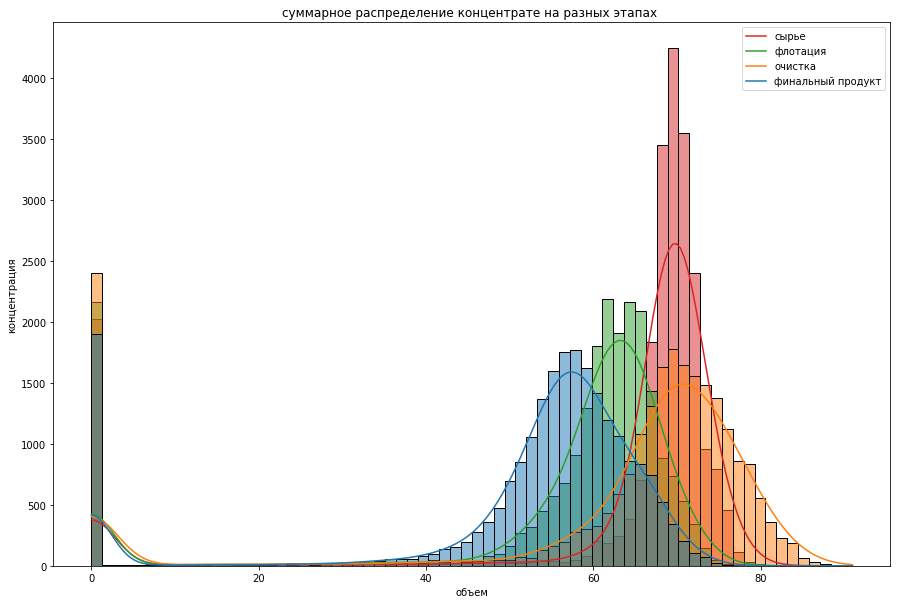

In [44]:
pfull()

In [30]:
gold_full = gold_full.drop(gold_full[(gold_full['rougher.input.feed_ag'] == 0) & (gold_full['rougher.input.feed_au'] == 0) & (gold_full['rougher.input.feed_pb'] == 0) & (gold_full['rougher.input.feed_sol'] == 0)].index)
gold_full = gold_full.drop(gold_full[(gold_full['rougher.output.concentrate_ag'] == 0) & (gold_full['rougher.output.concentrate_au'] == 0) & (gold_full['rougher.output.concentrate_pb'] == 0) & (gold_full['rougher.output.concentrate_sol'] == 0)].index)
gold_full = gold_full.drop(gold_full[(gold_full['primary_cleaner.output.concentrate_ag'] == 0) & (gold_full['primary_cleaner.output.concentrate_au'] == 0) & (gold_full['primary_cleaner.output.concentrate_pb'] == 0) & (gold_full['primary_cleaner.output.concentrate_sol'] == 0)].index)
gold_full = gold_full.drop(gold_full[(gold_full['final.output.concentrate_ag'] == 0) & (gold_full['final.output.concentrate_au'] == 0) & (gold_full['final.output.concentrate_pb'] == 0) & (gold_full['final.output.concentrate_sol'] == 0)].index)

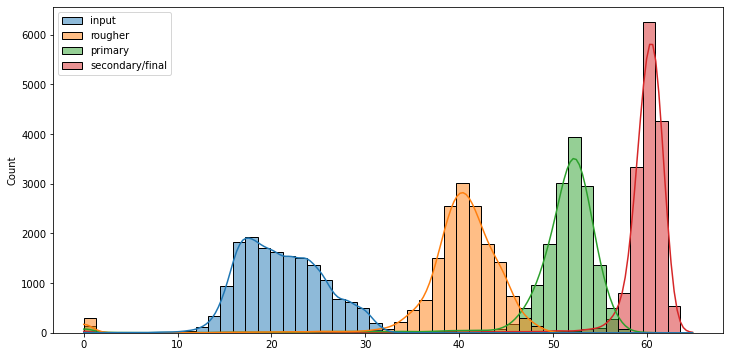

## Построение моделей

### пишем фукнцию sMAPE  
фукнцию sMAPE вроде получилось написать, а функцию итоговой sMAPE написать не получилось. и как правильно её вызвать тоже ума не приложу

In [32]:
#def smape(target, predict):
    #return 1/len(target) * np.sum(np.abs(target - predict) / ((np.abs(target) + np.abs(predict)) / 2)) * 100

#itog_smape = (0.25 * sMAPE(gold_test['rougher.output.recovery'])) + (0.75 * sMAPE(gold_test['final.output.recovery']))
#print(smape(gold_test['rougher.output.recovery'], gold_test['final.output.recovery'])) # проверял функцию
def smape(target_1, predictions):
    a = abs(target_1 - predictions) 
    b = (abs(target_1) + abs(predictions)) / 2 
    errors = a / b 
    return errors.sum()/ errors.shape[0] * 100

def ismape(smape_rougher, smape_final): 
    result = 0.25*(smape_rougher) + 0.75*(smape_final)
    return result

In [36]:
model = LinearRegression()

scores_roug = cross_val_score(model, features_train, target_train_roug, scoring=make_scorer(smape, greater_is_better=False), cv=3)
final_score = scores_roug.mean()


print('Средняя SMAPE:', final_score)

Средняя SMAPE: -13.27444632429283


In [37]:
model = LinearRegression()

scores_final = cross_val_score(model, features_train, target_train_final, scoring=make_scorer(smape, greater_is_better=False), cv=3)
final_score = scores_final.mean()

print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -11.011485500874757


In [40]:
print("Итоговой sMAPE модели LinearRegression", ismape(scores_roug, scores_final).mean())

Итоговой sMAPE модели LinearRegression -11.577225706729275


In [56]:
model = DecisionTreeClassifier(random_state=12345)

scores_roug = cross_val_score(model, features_train, target_train_roug, scoring=make_scorer(smape, greater_is_better=False), cv=3)
final_score = scores_roug.mean()


print('Средняя SMAPE:', final_score)



Средняя SMAPE: -17.64809471827795


In [57]:
model = DecisionTreeClassifier(random_state=12345)

scores_final = cross_val_score(model, features_train, target_train_final, scoring=make_scorer(smape, greater_is_better=False), cv=3)
final_score = scores_final.mean()

print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -15.95671726387547


In [58]:
print("Итоговой sMAPE модели DecisionTreeClassifier", ismape(scores_roug, scores_final))

Итоговой sMAPE модели DecisionTreeClassifier [-12.62284543 -22.10986522 -14.40597423]


In [59]:
for depth in range(1, 11):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scores_roug = cross_val_score(model, features_train, target_train_roug, scoring=make_scorer(smape, greater_is_better=False), cv=3) 
final_score = scores_roug.mean()

print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -19.88048613431383


In [60]:
for depth in range(1, 11):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    scores_final = cross_val_score(model, features_train, target_train_final, scoring=make_scorer(smape, greater_is_better=False), cv=3) 
final_score = scores_final.mean()

print('Средняя оценка качества модели:', final_score)

Средняя оценка качества модели: -14.91551946027758


In [61]:
print("Итоговой sMAPE модели DecisionTreeRegressor", ismape(scores_roug, scores_final))

Итоговой sMAPE модели DecisionTreeRegressor [-19.55382076 -13.52479293 -15.3916697 ]


In [62]:
dummy_regressor_rougher = DummyRegressor(strategy="median")
dummy_regressor_rougher.fit(features_train, target_train_roug)
dummy_rougher_pred = dummy_regressor_rougher.predict(features_test)
smape_dummy_rougher = smape(target_test_roug, dummy_rougher_pred)
print('smape_dummy', smape_dummy_rougher)

smape_dummy 8.971344658843252


In [63]:
dummy_regressor_final = DummyRegressor(strategy="median")
dummy_regressor_final.fit(features_train, target_train_final)
dummy_final_pred = dummy_regressor_final.predict(features_test)
smape_dummy_final = smape(target_test_final, dummy_final_pred)
print('smape_dummy', smape_dummy_final)

smape_dummy 9.259526410378458
